Exception ignored in: <finalize object at 0x1b3c1f40580; dead>
Traceback (most recent call last):
  File "c:\Environment\MiniConda\envs\backend\lib\weakref.py", line 591, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "c:\Environment\MiniConda\envs\backend\lib\tempfile.py", line 820, in _cleanup
    cls._rmtree(name)
  File "c:\Environment\MiniConda\envs\backend\lib\tempfile.py", line 816, in _rmtree
    _shutil.rmtree(name, onerror=onerror)
  File "c:\Environment\MiniConda\envs\backend\lib\shutil.py", line 759, in rmtree
    return _rmtree_unsafe(path, onerror)
  File "c:\Environment\MiniConda\envs\backend\lib\shutil.py", line 629, in _rmtree_unsafe
    onerror(os.unlink, fullname, sys.exc_info())
  File "c:\Environment\MiniConda\envs\backend\lib\tempfile.py", line 808, in onerror
    cls._rmtree(path)
  File "c:\Environment\MiniConda\envs\backend\lib\tempfile.py", line 816, in _rmtree
    _shutil.rmtree(name, onerror=onerror)
  File "c:\Environment\MiniCon

FloPy is using the following executable to run the model: ..\..\AppData\Local\flopy\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Pumping_problem.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/06/13 10:46:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/06/13 10:46:34
 Elapsed run time:  0.020 Seconds

  Normal termination of simulation
(1, 11, 11)


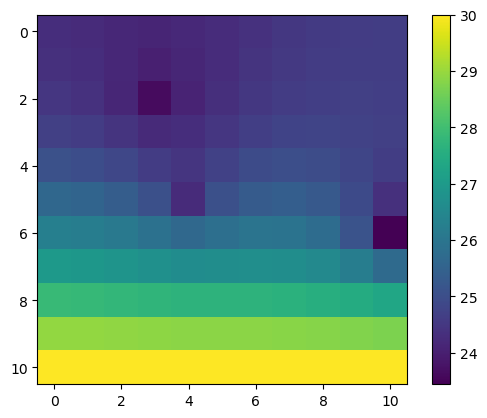

In [18]:
import os
import numpy as np
import pandas as pd
import flopy
from tempfile import TemporaryDirectory

# dirpath = os.path.dirname(__file__)
# sim_ws = os.path.join(dirpath, "../modelCache")


temp_dir = TemporaryDirectory()
sim_ws = os.path.join(temp_dir.name)
sim_ws = "C:/Users/ART/Desktop/mf6"
modelname = "Pumping_problem"
mf = flopy.modflow.Modflow(
    modelname=modelname,
    exe_name="mf2005",
    version="mf2005",
    model_ws=sim_ws,
)

# 2. 离散DIS
Lx = 11000.0  # x 长度
Ly = 11000.0  # y 长度
ztop = 30  # z 顶部高程
zbot = -10  # z 底部高程
nlay = 1  # 含水层层数
nrow = 11  # 行数
ncol = 11  # 列数
delr = Lx / ncol  # x 方向步长
delc = Ly / nrow  # y 方向步长
botm = np.linspace(ztop, zbot, nlay + 1)  # z 每一层的底部高程
nper = 1  # 应力期数
perlen = [1000]  # 每个应力期的时间长度
nstp = [1]  # 每个应力期的时间步数
steady = [True]  # 每个应力期是否稳态
# Unit System
itmuni = 4  # time units (0=undefined,1=seconds,2=minutes,3=hours,4=days, default:4)
lenuni = 2  # lenght units (0=undefined,1=feet,2=meters, 3=centimeters,defaut:2)
dis = flopy.modflow.ModflowDis(
    model=mf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=ztop,
    botm=botm[1:],
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    steady=steady,
    itmuni=itmuni,
    lenuni=lenuni,
)
# 3. 基础包BAS
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, 10, :] = -1
strt = np.full([11, 11], 30, dtype=float)  # 初始水头为30

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
# 4. LPF
vka = 10  # 当layvka>0时，vka表示水平渗透系数和垂直渗透系数的比值
icelltype = 1  # 潜水含水层
k11 = np.full([11, 11], 90)  # 渗透系数
k11[:4, :6] = 150
k11[8:, :] = 60
k11[5:8, 9:] = 60
# 水平各项异性默认为1，贮水率使用默认值。潜水含水层
lpf = flopy.modflow.ModflowLpf(mf, laytyp=1, hk=k11, ipakcb=53)
###################################################################################################
# 5. CHD 常水头边界
chd_spd = []
for i in np.arange(ncol):
    chd_spd.append([0, 10,i, 30.0, 30.0])### layer, row, column, stage, conductance, river bottom
stress_period_data = {0: chd_spd}
# Create the flopy chd object
chd = flopy.modflow.ModflowChd(mf, stress_period_data=stress_period_data)
#################################################################################################
# 6. 通过在右边界设置一排井来表示指定流量边界
wel_spd = [[0, 2, 3, -10000], [0, 5, 4, -10000], [0, 6, 10, -10000]]
stress_period_data = {0: wel_spd}
# note 当ipakcb大于0时，才会保存.cbc文件
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)
###################################################################################################
# 7. OC
# 每个时间步结束保存水头
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = [
            "save head",  # 保存水头
            "save drawdown",  # 保存水头降落
            "save budget",  # 保存水量收支
            "print head",
            "print budget",
        ]
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data, compact=True)
# 9. PCG 求解器
pcg = flopy.modflow.ModflowPcg(mf)

# 尝试删除输出文件，防止使用之前的旧文件
# try:
#     delete_files_in_directory(sim_ws)
#     # os.remove(os.path.join(sim_ws, sim_name + ".ccf"))
# except FileNotFoundError:
#     pass

# 写入输入文件
mf.write_input()
# 运行水流模型
success, mfoutput = mf.run_model(silent=False)
assert success, "MODFLOW did not terminate normally!"
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt
hds = bf.HeadFile(os.path.join(sim_ws, modelname + ".hds"))
# budg = bf.CellBudgetFile(os.path.join(sim_ws, sim_name + ".ccf"))
head = hds.get_data()
print(head.shape)
plt.imshow(head[0])
plt.colorbar()

In [9]:
Lx = 11000.0  # x 长度
Ly = 11000.0  # y 长度
ztop = 30  # z 顶部高程
zbot = -10  # z 底部高程
nlay = 1  # 含水层层数
nrow = 11  # 行数
ncol = 11  # 列数
delr = Lx / ncol  # x 方向步长
delc = Ly / nrow  # y 方向步长
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, 10, :] = -1  # 最左边的列是常水头边界
print(ibound)

[[[ 1  1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [14]:
chd_spd = []
for i in np.arange(ncol):
    chd_spd.append([0, 10, i, 30.0])
print(chd_spd)

[[0, 10, 0, 30.0], [0, 10, 1, 30.0], [0, 10, 2, 30.0], [0, 10, 3, 30.0], [0, 10, 4, 30.0], [0, 10, 5, 30.0], [0, 10, 6, 30.0], [0, 10, 7, 30.0], [0, 10, 8, 30.0], [0, 10, 9, 30.0], [0, 10, 10, 30.0]]


In [15]:
chd_new = []
for i in np.arange(ncol):
    chd_new.append([0, 0, 10, i, 30.0])
print(chd_new)

[[0, 0, 10, 0, 30.0], [0, 0, 10, 1, 30.0], [0, 0, 10, 2, 30.0], [0, 0, 10, 3, 30.0], [0, 0, 10, 4, 30.0], [0, 0, 10, 5, 30.0], [0, 0, 10, 6, 30.0], [0, 0, 10, 7, 30.0], [0, 0, 10, 8, 30.0], [0, 0, 10, 9, 30.0], [0, 0, 10, 10, 30.0]]
